# Importing Libraries

In [34]:
!pip install jovian --upgrade --quiet
import jovian
import torch
import torchvision
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms as tt
import torch.nn.functional as F
from torchvision import datasets, models
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline


In [35]:
project_name='course-project-feedforward'

# Importing Data and Creating Relevant Datasets and Dataloaders

In [36]:
base_tfms = tt.Compose([tt.Resize((109,109)),
                        tt.ToTensor()])

In [37]:
img_dir='../input/cell-images-for-detecting-malaria/cell_images'
dataset = datasets.ImageFolder(img_dir,transform = base_tfms)

In [38]:
random_seed = 87
torch.manual_seed(random_seed);

In [39]:
val_pct = 0.20
test_pct = 0.10
val_size = int(val_pct * len(dataset))
test_size = int(test_pct * len(dataset))
train_size = len(dataset) - val_size - test_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(38582, 11023, 5511)

In [71]:
batch_size = 36
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

# Data Augmentation

In [44]:
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(),
                         tt.Resize((109,109)),
                         tt.ToTensor(), 
                         tt.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225],inplace=True)])

test_tfms = tt.Compose([tt.Resize((109,109)),
                        tt.ToTensor(),
                        tt.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

In [73]:
train_ds.dataset.transform = train_tfms
val_ds.dataset.transform = test_tfms
test_ds.dataset.transform = test_tfms

# Displaying a batch

In [74]:
def show_sample(img, target, invert=True):
    if invert:
        plt.imshow(1 - img.permute((1, 2, 0)))
    else:
        plt.imshow(img.permute(1, 2, 0))
    print(target)

2


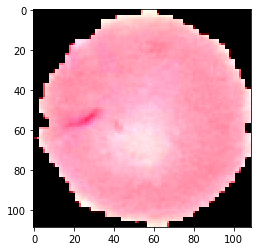

In [75]:
show_sample(*test_ds[0], invert=False)

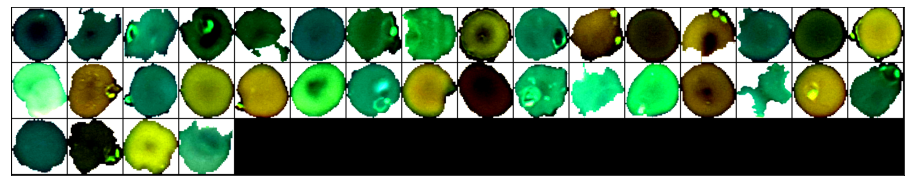

In [76]:
def show_batch(dl, invert=True):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        data = 1-images if invert else images
        ax.imshow(make_grid(data, nrow=16).permute(1, 2, 0))
        break
        
show_batch(train_dl)

# Moving The Dataloaders to GPU if Availible

In [46]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [47]:
device = get_default_device()
device

device(type='cpu')

In [65]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

In [66]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/moaaz645/course-project-feedforward


<IPython.core.display.Javascript object>

# Defining The Model

In [50]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc


In [51]:
class MalariaModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        labels = labels.view(-1,1)
        out = self(images)                  # Generate predictions
        loss = nn.L1Loss()(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        labels = labels.view(-1,1)
        out = self(images)                    # Generate predictions
        loss = nn.L1Loss()(out, labels)   # Calculate loss
        acc = binary_acc(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [52]:
model = MalariaModel(35643,256,1)
to_device(model, device)

MalariaModel(
  (linear1): Linear(in_features=35643, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=1, bias=True)
)

# Training 

In [53]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [54]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.174870252609253, 'val_acc': 27.227272033691406}]

In [55]:
history += fit(5, 0.4, model, train_dl, val_dl)

Epoch [0], val_loss: 0.7477, val_acc: 25.0065
Epoch [1], val_loss: 0.7483, val_acc: 25.0065
Epoch [2], val_loss: 0.7489, val_acc: 25.0065
Epoch [3], val_loss: 0.7497, val_acc: 25.0065
Epoch [4], val_loss: 0.7488, val_acc: 25.0065


In [56]:
history += fit(5, 0.08, model, train_dl, val_dl)

Epoch [0], val_loss: 0.7489, val_acc: 25.0065
Epoch [1], val_loss: 0.7489, val_acc: 25.0065
Epoch [2], val_loss: 0.7490, val_acc: 25.0065
Epoch [3], val_loss: 0.7490, val_acc: 25.0065
Epoch [4], val_loss: 0.7490, val_acc: 25.0065


In [57]:
history += fit(5, 0.005, model, train_dl, val_dl)

Epoch [0], val_loss: 0.7490, val_acc: 25.0065
Epoch [1], val_loss: 0.7490, val_acc: 25.0065
Epoch [2], val_loss: 0.7490, val_acc: 25.0065
Epoch [3], val_loss: 0.7490, val_acc: 25.0065
Epoch [4], val_loss: 0.7491, val_acc: 25.0065


In [59]:
history += fit(3, 0.0003, model, train_dl, val_dl)

Epoch [0], val_loss: 0.7491, val_acc: 25.0065
Epoch [1], val_loss: 0.7491, val_acc: 25.0065
Epoch [2], val_loss: 0.7491, val_acc: 25.0065


# Displaying Results

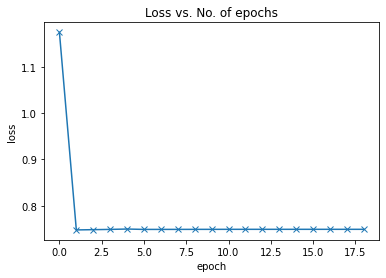

In [67]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
    
plot_losses(history)

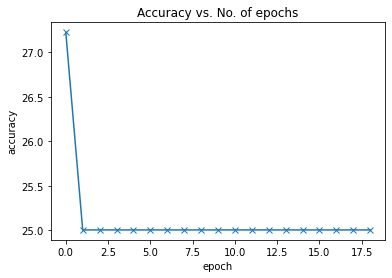

In [68]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
    
plot_accuracies(history)

In [77]:
evaluate(model, test_dl)

{'val_loss': 0.7438824772834778, 'val_acc': 25.558441162109375}

# Saving Results

In [78]:
architecture = "Basic feedforward model with 1 hidden layer"
lrs = [0.4,0.08,0.005,0.0003]
epochs = [5,5,5,3]
test_acc = 25.558441162109375
test_loss = 0.7438824772834778

In [80]:
torch.save(model.state_dict(), 'malaria-feedforward.pth')
jovian.reset()
jovian.log_hyperparams(architecture=architecture, 
                       lrs=lrs, 
                       epochs=epochs)
jovian.log_metrics(test_loss=test_loss, test_acc=test_acc)
jovian.commit(project=project_name, outputs=['malaria-feedforward.pth'], environment=None)

[jovian] Hyperparams logged.
[jovian] Metrics logged.


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ml/moaaz645/course-project-feedforward


<IPython.core.display.Javascript object>